<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Quite Complex Portfolios 

This part illustrates that you can **model, value and risk manage quite complex derivatives portfolios** with DX Analytics.

In [1]:
from dx import *
import time
from pylab import plt
plt.style.use('seaborn-v0_8')
%matplotlib inline
np.random.seed(10000)

## Multiple Risk Factors

The example is based on a **multiple, correlated risk factors**, all (for the ease of exposition) `geometric_brownian_motion` objects.

In [2]:
mer = market_environment(name='me', pricing_date=dt.datetime(2015, 1, 1))
mer.add_constant('initial_value', 0.01)
mer.add_constant('volatility', 0.1)
mer.add_constant('kappa', 2.0)
mer.add_constant('theta', 0.05)
mer.add_constant('paths', 100) # dummy
mer.add_constant('frequency', 'M') # dummy
mer.add_constant('starting_date', mer.pricing_date)
mer.add_constant('final_date', dt.datetime(2015, 12, 31)) # dummy
ssr = stochastic_short_rate('ssr', mer)

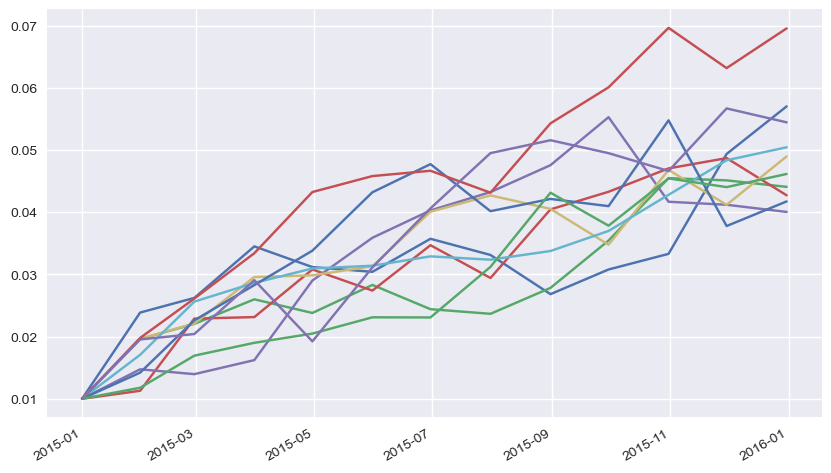

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(ssr.process.time_grid, ssr.process.get_instrument_values()[:, :10]);
plt.gcf().autofmt_xdate()

In [4]:
# market environments
me = market_environment('gbm', dt.datetime(2015, 1, 1))

In [5]:
# geometric Brownian motion
me.add_constant('initial_value', 36.)
me.add_constant('volatility', 0.2) 
me.add_constant('currency', 'EUR')

In [6]:
# jump diffusion
me.add_constant('lambda', 0.4)
me.add_constant('mu', -0.4) 
me.add_constant('delta', 0.2)

In [7]:
# stochastic volatility
me.add_constant('kappa', 2.0)
me.add_constant('theta', 0.3) 
me.add_constant('vol_vol', 0.5)
me.add_constant('rho', -0.5)

Using 2,500 paths and monthly discretization for the example.

In [8]:
# valuation environment
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))
val_env.add_constant('paths', 1000)
val_env.add_constant('frequency', 'M')
val_env.add_curve('discount_curve', ssr)
val_env.add_constant('starting_date', dt.datetime(2015, 1, 1))
val_env.add_constant('final_date', dt.datetime(2016, 12, 31))

In [9]:
# add valuation environment to market environments
me.add_environment(val_env)

In [10]:
no = 50  # 50 different risk factors in total

In [11]:
risk_factors = {}
for rf in range(no):
    # random model choice
    sm = np.random.choice(['gbm', 'jd', 'sv'])
    key = '%3d_%s' % (rf + 1, sm)
    risk_factors[key] = market_environment(key, me.pricing_date)
    risk_factors[key].add_environment(me)
    # random initial_value
    risk_factors[key].add_constant('initial_value',
                                    np.random.random() * 40. + 20.)
    # radnom volatility
    risk_factors[key].add_constant('volatility',
                                    np.random.random() * 0.6 + 0.05)
    # the simulation model to choose
    risk_factors[key].add_constant('model', sm)

In [12]:
correlations = []
keys = sorted(risk_factors.keys())
for key in keys[1:]:
    correlations.append([keys[0], key, np.random.choice([-0.1, 0.0, 0.1])])
correlations[:3]

[['  1_sv', '  2_gbm', np.float64(0.1)],
 ['  1_sv', '  3_gbm', np.float64(-0.1)],
 ['  1_sv', '  4_gbm', np.float64(-0.1)]]

## Options Modeling

We model a certain number of **derivative instruments** with the following major assumptions.

In [13]:
me_option = market_environment('option', me.pricing_date)
# choose from a set of maturity dates (month ends)
maturities = pd.date_range(start=me.pricing_date,
                           end=val_env.get_constant('final_date'),
                           freq='M').to_pydatetime()
me_option.add_constant('maturity', np.random.choice(maturities))
me_option.add_constant('currency', 'EUR')
me_option.add_environment(val_env)

## Portfolio Modeling

The `derivatives_portfolio` object we compose consists of **multiple derivatives positions**. Each option differs with respect to the strike and the risk factor it is dependent on.

In [14]:
# 5 times the number of risk factors
# as portfolio positions/instruments
pos = 5 * no              

In [15]:
positions = {}
for i in range(pos):
    ot = np.random.choice(['am_put', 'eur_call'])
    if ot == 'am_put':
        otype = 'American single'
        payoff_func = 'np.maximum(%5.3f - instrument_values, 0)'
    else:
        otype = 'European single'
        payoff_func = 'np.maximum(maturity_value - %5.3f, 0)'
    # random strike
    strike = np.random.randint(36, 40)
    underlying = sorted(risk_factors.keys())[(i + no) % no]
    name = '%d_option_pos_%d' % (i, strike)
    positions[name] = derivatives_position(
                        name=name,
                        quantity=np.random.randint(1, 10),
                        underlyings=[underlying],
                        mar_env=me_option,
                        otype=otype,
        payoff_func=payoff_func % strike)

In [16]:
# number of derivatives positions
len(positions)

250

## Portfolio Valuation

First, the derivatives portfolio with **sequential valuation**.

In [17]:
port = derivatives_portfolio(
                name='portfolio',
                positions=positions,
                val_env=val_env,
                risk_factors=risk_factors,
                correlations=correlations,
                parallel=False)  # sequential calculation

In [18]:
port.val_env.get_list('cholesky_matrix')

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1       ,  0.99498744,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1       ,  0.01005038,  0.99493668, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.1       ,  0.01005038, -0.01015242, ...,  0.99239533,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.1       , -0.01005038,  0.01015242, ...,  0.01526762,
         0.        ,  0.99227788]], shape=(50, 50))

The call of the `get_values` method to **value all instruments**.

In [19]:
%time res = port.get_statistics(fixed_seed=True)

Totals
 pos_value    10400.2920
pos_delta      116.0584
pos_vega      8477.9800
dtype: float64
CPU times: user 1min 2s, sys: 2.65 s, total: 1min 5s
Wall time: 15.4 s


In [20]:
res.set_index('position', inplace=False)

,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
position,,,,,,,,,
0_option_pos_38,0_option_pos_38,6,European single,[ 1_sv],7.263,EUR,43.578,3.6036,22.7046
1_option_pos_39,1_option_pos_39,8,American single,[ 2_gbm],5.398,EUR,43.184,-3.9168,124.5688
2_option_pos_37,2_option_pos_37,3,European single,[ 3_gbm],3.306,EUR,9.918,1.9935,42.8949
3_option_pos_37,3_option_pos_37,8,American single,[ 4_gbm],9.097,EUR,72.776,-8.0000,5.3336
4_option_pos_39,4_option_pos_39,1,European single,[ 5_gbm],17.664,EUR,17.664,0.7531,13.4445
...,...,...,...,...,...,...,...,...,...
245_option_pos_36,245_option_pos_36,5,European single,[ 46_gbm],22.709,EUR,113.545,4.7900,-2.6650
246_option_pos_37,246_option_pos_37,4,European single,[ 47_sv],2.635,EUR,10.540,1.5900,3.7216
247_option_pos_39,247_option_pos_39,3,American single,[ 48_sv],11.420,EUR,34.260,-1.4394,6.6159


## Risk Analysis

**Full distribution of portfolio present values** illustrated via histogram.

In [21]:
%time pvs = port.get_present_values()

CPU times: user 11.5 s, sys: 611 ms, total: 12.1 s
Wall time: 3.07 s


Text(0, 0.5, 'frequency')

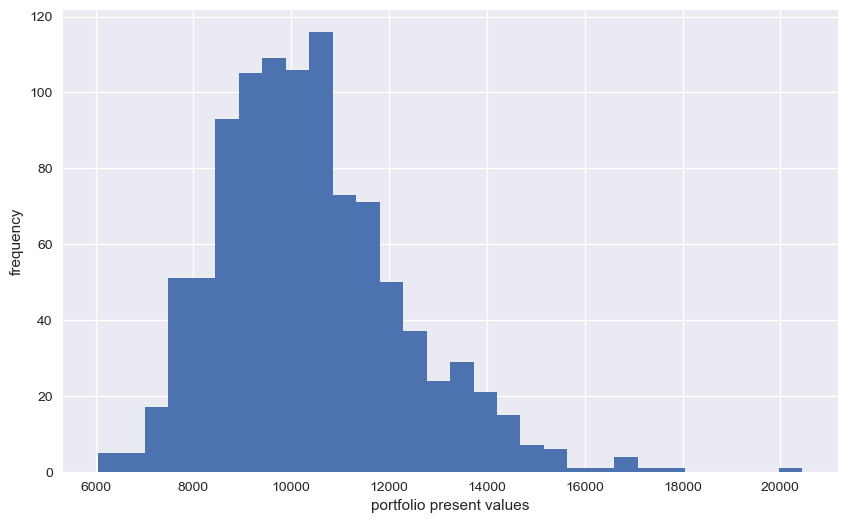

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(pvs, bins=30);
plt.xlabel('portfolio present values')
plt.ylabel('frequency')

Some **statistics** via pandas.

In [23]:
pdf = pd.DataFrame(pvs)
pdf.describe()

,0
count,1000.000000
mean,10385.491824
std,1891.255451
min,6045.025829
25%,9059.919260
50%,10189.486685
75%,11436.385373
max,20446.938649


The **delta** risk report.

In [24]:
%%time
deltas, benchmark = port.get_port_risk(Greek='Delta', fixed_seed=True, step=0.2,
                                       risk_factors=list(risk_factors.keys())[:4])
risk_report(deltas)


  1_sv
0.8
1.0
1.2

  2_gbm
0.8
1.0
1.2

  3_gbm
0.8
1.0
1.2

  4_gbm
0.8
1.0
1.2




  1_sv_Delta
dim_0  dim_1 
0.8    factor       28.73
       value     10318.88
1.0    factor       35.91
       value     10385.48
1.2    factor       43.09
       value     10490.80
Name:   1_sv_Delta, dtype: float64

  2_gbm_Delta
dim_0  dim_1 
0.8    factor       30.36
       value     10410.14
1.0    factor       37.95
       value     10385.48
1.2    factor       45.54
       value     10391.22
Name:   2_gbm_Delta, dtype: float64

  3_gbm_Delta
dim_0  dim_1 
0.8    factor       30.04
       value     10440.04
1.0    factor       37.55
       value     10385.48
1.2    factor       45.06
       value     10421.06
Name:   3_gbm_Delta, dtype: float64

  4_gbm_Delta
dim_0  dim_1 
0.8    factor       22.29
       value     10429.74
1.0    factor       27.87
       value     10385.48
1.2    factor       33.44
       value     10351.02
Name:   4_gbm_Delta, dtype: float64
CPU times: user 14.4 s, sys: 714

The **vega** risk report.

In [25]:
%%time
vegas, benchmark = port.get_port_risk(Greek='Vega', fixed_seed=True, step=0.2,
                                      risk_factors=list(risk_factors.keys())[:3])
risk_report(vegas)


  1_sv
0.8
1.0
1.2

  2_gbm
0.8
1.0
1.2

  3_gbm
0.8
1.0
1.2




  1_sv_Vega
dim_0  dim_1 
0.8    factor        0.42
       value     10377.30
1.0    factor        0.52
       value     10384.95
1.2    factor        0.62
       value     10402.19
Name:   1_sv_Vega, dtype: float64

  2_gbm_Vega
dim_0  dim_1 
0.8    factor        0.27
       value     10365.33
1.0    factor        0.34
       value     10384.95
1.2    factor        0.41
       value     10404.53
Name:   2_gbm_Vega, dtype: float64

  3_gbm_Vega
dim_0  dim_1 
0.8    factor        0.12
       value     10374.04
1.0    factor        0.14
       value     10384.95
1.2    factor        0.17
       value     10395.83
Name:   3_gbm_Vega, dtype: float64
CPU times: user 13 s, sys: 693 ms, total: 13.7 s
Wall time: 3.44 s


## Visualization of Results

Selected **results visualized**.

Text(0, 0.5, 'frequency')

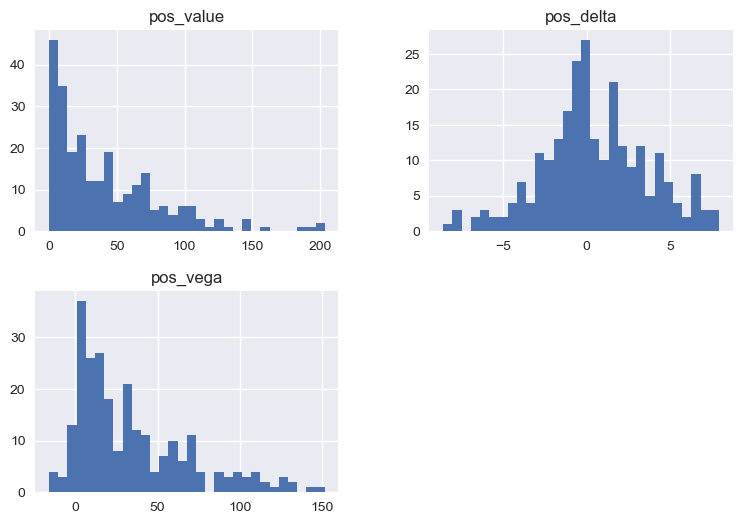

In [26]:
res[['pos_value', 'pos_delta', 'pos_vega']].hist(bins=30, figsize=(9, 6))
plt.ylabel('frequency')

**Sample paths** for three underlyings.

In [27]:
paths_0 = list(port.underlying_objects.values())[0]
paths_0.generate_paths()
paths_1 = list(port.underlying_objects.values())[1]
paths_1.generate_paths()
paths_2 = list(port.underlying_objects.values())[2]
paths_2.generate_paths()

Paths for  30_gbm (blue)
Paths for   4_gbm (red)
Paths for   7_jd (green)


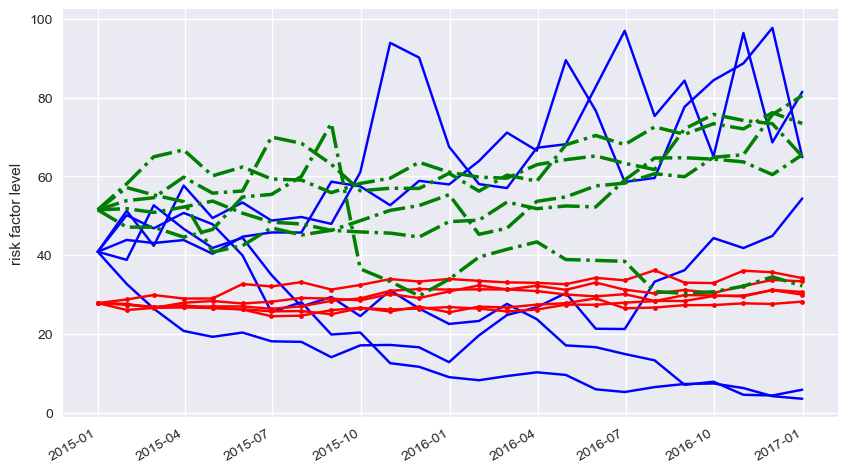

In [28]:
pa = 5
plt.figure(figsize=(10, 6))
plt.plot(port.time_grid, paths_0.instrument_values[:, :pa], 'b');
print('Paths for %s (blue)' % paths_0.name)
plt.plot(port.time_grid, paths_1.instrument_values[:, :pa], 'r.-');
print ('Paths for %s (red)' % paths_1.name)
plt.plot(port.time_grid, paths_2.instrument_values[:, :pa], 'g-.', lw=2.5);
print('Paths for %s (green)' % paths_2.name)
plt.ylabel('risk factor level')
plt.gcf().autofmt_xdate()

**Copyright, License & Disclaimer**

© Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library" or "dx package") is licensed under the GNU Affero General
Public License version 3 or later (see http://www.gnu.org/licenses/).

DX Analytics comes with no representations or warranties, to the extent
permitted by applicable law.

[Learn More & Stay in Touch](https://linktr.ee/dyjh)

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>